# Functions

In [ ]:
from LM_align.synthData.SynthCommon import *

# Generate Dataset

In [ ]:
# 预生成数据
output_dir = 'pre_generated_data'  # 生成数据的目录
num_samples = 500  # 根据需要调整样本数量
skipped = pre_generate_dataset(num_samples, output_dir,
                               canvas_size=(256, 256),
                               min_size=20, max_size=40,
                               max_attempts=1000, max_retry=5)

Draw star, box=(164, 9, 32, 24), font_size=24
Draw star, text_x=163.5, text_y=9.5
Draw star, box=(164, 9, 32, 24), font_size=24
Draw star, text_x=163.5, text_y=9.5
Saved sample 0: {'obj': 'star', 'a': 0, 'b': 1, 'c': 1}
Draw star, box=(82, 121, 21, 40), font_size=21
Draw star, text_x=78.0, text_y=130.5
Draw star, box=(82, 121, 21, 40), font_size=21
Draw star, text_x=78.0, text_y=130.5
Saved sample 1: {'obj': 'star', 'a': 1, 'b': 0, 'c': 1}
Draw star, box=(151, 203, 28, 34), font_size=28
Draw star, text_x=146.0, text_y=206.5
Draw star, box=(151, 203, 28, 34), font_size=28
Draw star, text_x=146.0, text_y=206.5
Saved sample 2: {'obj': 'star', 'a': 0, 'b': 1, 'c': 1}
Draw boat, box=(142, 126, 24, 22), font_size=22
Draw boat, text_x=139.0, text_y=125.5
Draw boat, box=(142, 126, 24, 22), font_size=22
Draw boat, text_x=139.0, text_y=125.5
Saved sample 3: {'obj': 'boat', 'a': 0, 'b': 1, 'c': 1}
Draw cat, box=(209, 93, 38, 32), font_size=32
Draw cat, text_x=206.0, text_y=93.0
Draw cat, box=(209

# Load data and test

dict_keys(['image_a', 'image_b', 'image_c', 'label'])


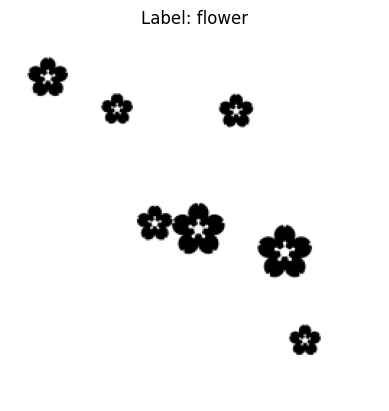

In [59]:
# 构建 Dataset 与 DataLoader
transform = transforms.ToTensor()
dataset = PreGeneratedDataset(output_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

# 测试读取一个 batch，并显示 sample 的 image_c
batch = next(iter(dataloader))
print(batch.keys())
sample_img = batch["image_c"][0].permute(1, 2, 0).numpy()
plt.imshow(sample_img)
label = batch["label"]["obj"][0]
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Draw apple, box=(50, 50, 100, 100), font_size=100
Draw apple, text_x=31.5, text_y=48.0


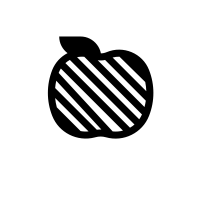

In [39]:
def draw_emoji(emoji_name, font_size=72):
    # 尝试完整路径
    font_path = "C:/Windows/Fonts/seguiemj.ttf"  # 或 seguiemoji.ttf
    emoji_char = EMOJI_MAP[emoji_name]

    image = Image.new("RGB", (200, 200), (255, 255, 255))
    draw = ImageDraw.Draw(image)

    try:
        emoji_font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print("Load emoji font failed:", e)
        emoji_font = ImageFont.load_default()

    # 在(50, 50)绘制
    
    # draw.text((50, 50), emoji_char, font=emoji_font, fill="black")
    draw_object(draw, emoji_name, (50, 50, 100, 100))
    display(image) 


draw_emoji("apple")

Draw apple, box=(151, 156, 47, 24), font_size=24
Draw apple, text_x=158.0, text_y=155.0
Draw apple, box=(33, 36, 45, 44), font_size=44
Draw apple, text_x=25.5, text_y=35.0
Draw apple, box=(173, 0, 21, 41), font_size=21
Draw apple, text_x=169.0, text_y=9.5
Draw apple, box=(38, 168, 20, 22), font_size=20
Draw apple, text_x=34.5, text_y=168.5
Draw apple, box=(27, 109, 42, 26), font_size=26
Draw apple, text_x=30.0, text_y=108.5
Draw apple, box=(77, 134, 33, 37), font_size=33
Draw apple, text_x=71.0, text_y=135.5
Draw apple, box=(109, 7, 50, 39), font_size=39
Draw apple, text_x=107.0, text_y=6.0
Draw apple, box=(81, 61, 26, 32), font_size=26
Draw apple, text_x=76.0, text_y=63.5
Draw apple, box=(112, 50, 33, 28), font_size=28
Draw apple, text_x=109.5, text_y=49.0
Draw apple, box=(114, 84, 34, 20), font_size=20
Draw apple, text_x=117.5, text_y=83.5
Draw apple, box=(169, 131, 20, 21), font_size=20
Draw apple, text_x=165.5, text_y=131.0
Draw apple, box=(122, 114, 38, 37), font_size=37
Draw appl

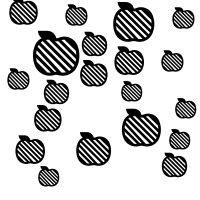

In [41]:
boxes = generate_non_overlapping_boxes(20, (200, 200), 20, 50)
img = draw_objects_on_image("apple", boxes, (200, 200))
display(img)

# Addition data distribution visualization

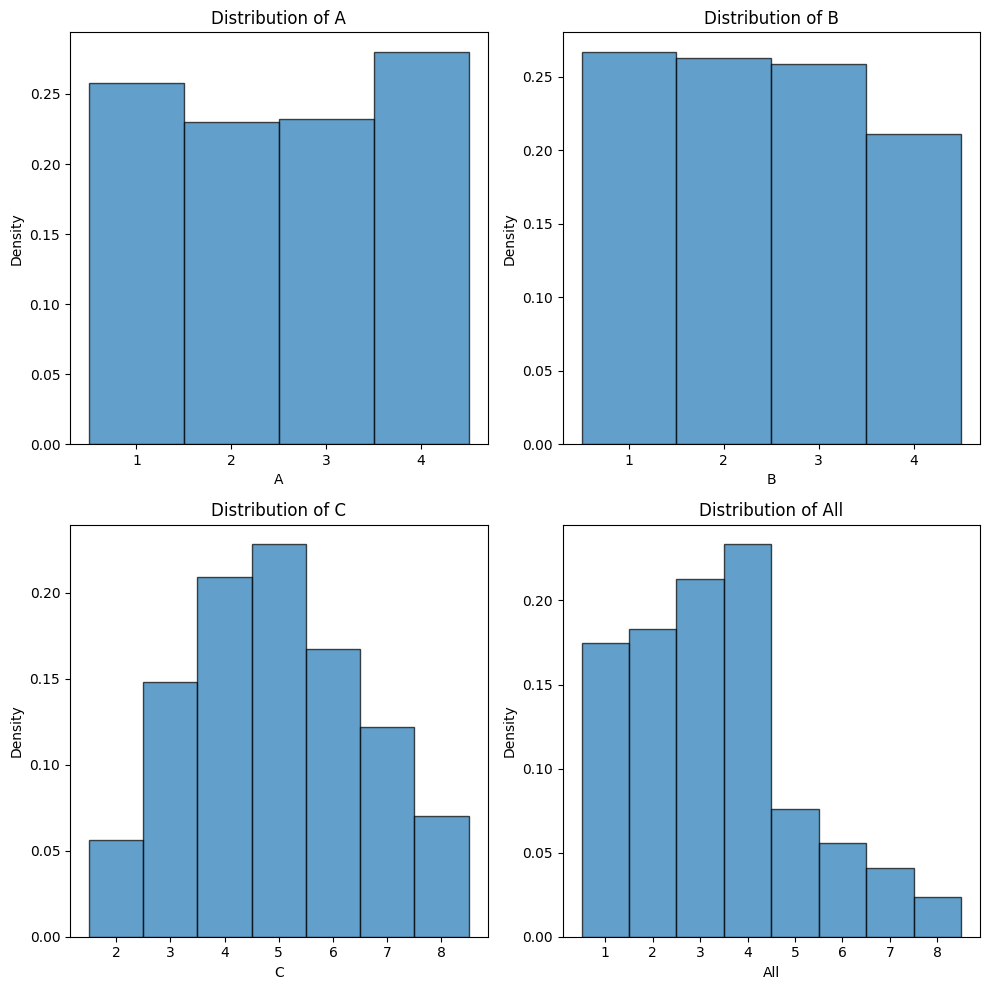

In [ ]:
import numpy as np
# 生成示例数据
np.random.seed(42)  # 固定随机种子
X = np.random.randint(1, 5, 1000)
Y = np.random.randint(1, 5, 1000)
plot_hist(X, Y)

# Shared-box data synth

In [11]:
import numpy as np
import random
from tqdm import tqdm

def gen_one_data_from_boxes_seq(boxes, a, b, obj_label, canvas_size):
    c = a + b
    n_idx = np.array(list(range(len(boxes))))
    a_idx = random.sample(list(n_idx), a)
    b_idx = random.sample(list(n_idx), b)
    c_idx = random.sample(list(n_idx), c)
    boxes_a = [boxes[i] for i in a_idx]
    boxes_b = [boxes[i] for i in b_idx]
    boxes_c = [boxes[i] for i in c_idx]

    image_a = draw_objects_on_image(obj_label, boxes_a, canvas_size)
    image_b = draw_objects_on_image(obj_label, boxes_b, canvas_size)
    image_c = draw_objects_on_image(obj_label, boxes_c, canvas_size)
    label = {"obj": obj_label, "a": a, "b": b, "c": c}
    return image_a, image_b, image_c, label


# ----------------------------
# 数据预生成函数：保存数据到本地
# ----------------------------
def pre_generate_oneSeqBox_dataset(num_samples, box_seq, output_dir, canvas_size=(224, 224), is_plot_hist=True):
    """
    预生成 num_samples 个数据点并保存到 output_dir 目录下。
    每个数据点保存在单独的文件夹中，包含 image_a.png, image_b.png, image_c.png 以及 label.json。
    如果某个数据点生成失败（如无法生成足够的 boxes），则跳过，并记录下来。
    """
    num_box = len(box_seq)
    os.makedirs(output_dir, exist_ok=True)
    generated = 0
    sample_index = 0
    seq_a = []
    seq_b = []
    for i in tqdm(range(num_samples)):
        obj_label = random.choice(OBJ_LIST)
        a = random.randint(1, 5)
        b = random.randint(1, 5)
        seq_a.append(a)
        seq_b.append(b)
        assert a + b <= num_box, f"Error: a + b = {a} + {b} = {a+b} > num_box = {num_box}"
        datapoint = gen_one_data_from_boxes_seq(box_seq, a, b, obj_label, canvas_size)
        image_a, image_b, image_c, label = datapoint
        # 保存到 sample_{index:04d} 文件夹下
        sample_dir = os.path.join(output_dir, f"sample_{sample_index:04d}")
        os.makedirs(sample_dir, exist_ok=True)
        image_a.save(os.path.join(sample_dir, "image_a.png"))
        image_b.save(os.path.join(sample_dir, "image_b.png"))
        image_c.save(os.path.join(sample_dir, "image_c.png"))
        # 保存 label 为 JSON 格式
        with open(os.path.join(sample_dir, "label.json"), "w", encoding="utf-8") as f:
            json.dump(label, f, ensure_ascii=False, indent=2)
        # print(f"Saved sample {sample_index}: {label}")
        generated += 1
        sample_index += 1

    print(f"Pre-generation complete. Generated {generated} samples.")
    if is_plot_hist:
        plot_hist(seq_a, seq_b)




100%|██████████| 2048/2048 [00:28<00:00, 72.13it/s]


Pre-generation complete. Generated 2048 samples.


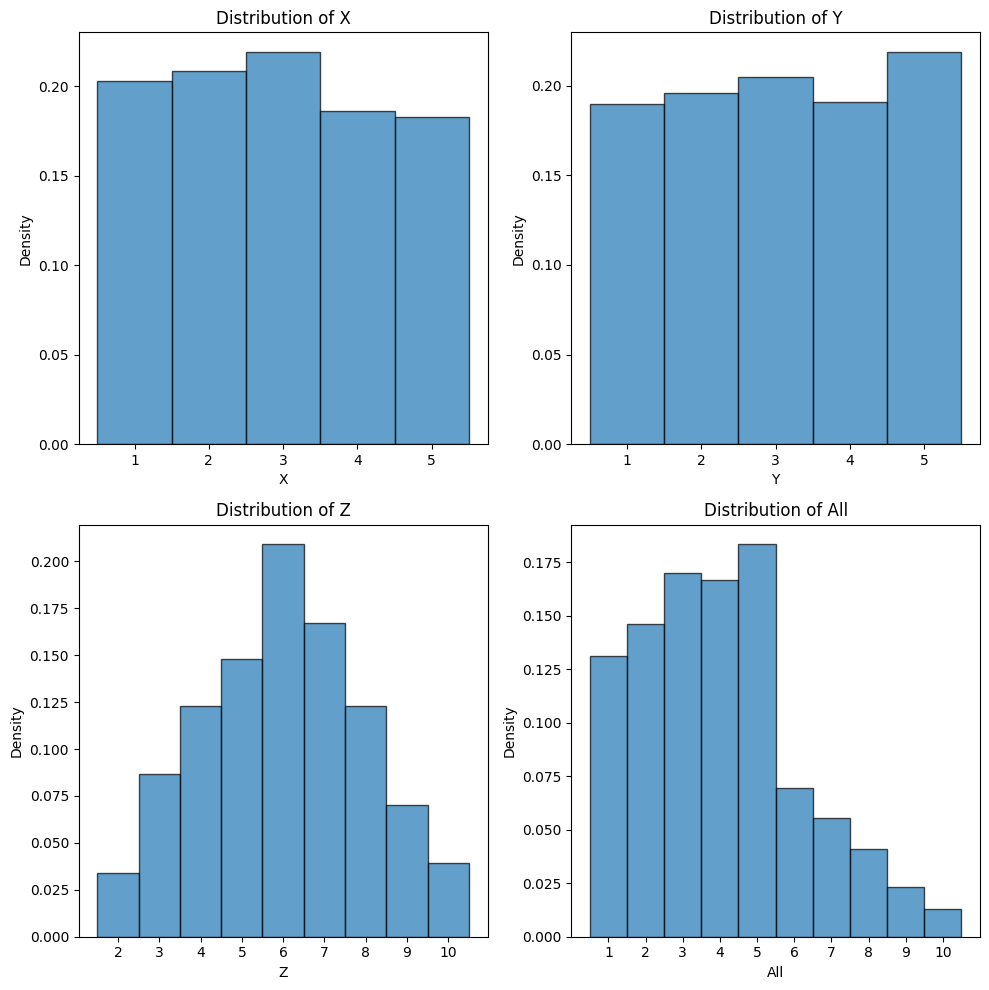

100%|██████████| 256/256 [00:03<00:00, 71.06it/s]

Pre-generation complete. Generated 256 samples.


In [12]:
num_samples_train = 2048 # 根据需要调整样本数量
num_samples_val = 256
output_dir_train = "pre_generated_data_sharedBoxes_train"
output_dir_val = "pre_generated_data_sharedBoxes_val"
num_box = 12
canvas_size = (224, 224)
min_size = 20
max_size = 40

box_seq = generate_non_overlapping_boxes(num_box, canvas_size, min_size, max_size, max_attempts=1000, max_retry=5)
pre_generate_oneSeqBox_dataset(num_samples_train, box_seq, output_dir_train, canvas_size=canvas_size)
pre_generate_oneSeqBox_dataset(num_samples_val, box_seq, output_dir_val, canvas_size=canvas_size, is_plot_hist=False)

# Recurrent Blindfold Synth

Generated 128 samples.
(<PIL.Image.Image image mode=RGB size=224x224 at 0x28514BEC1C0>, <PIL.Image.Image image mode=RGB size=224x224 at 0x2853BFF8D60>, <PIL.Image.Image image mode=RGB size=224x224 at 0x28514BED0F0>, {'obj': 'bicycle', 'a': 8, 'b': 1, 'c': 9})


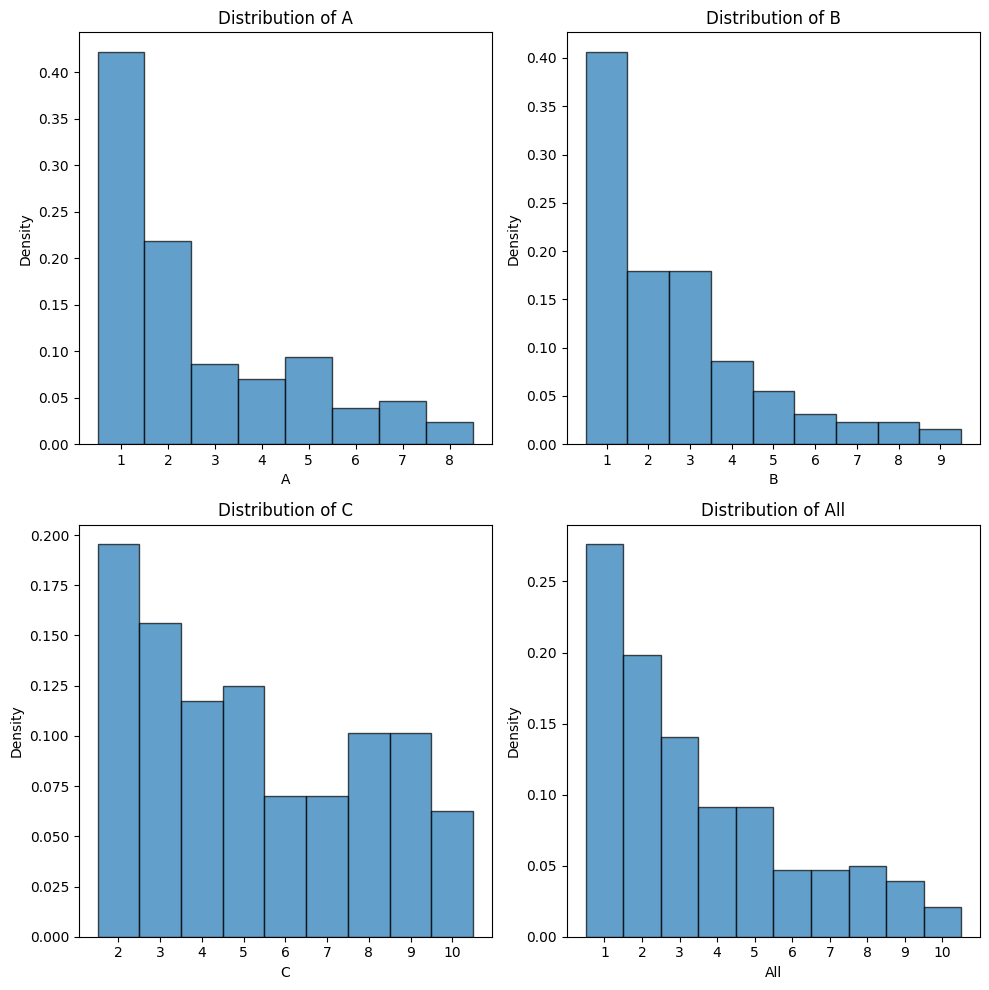

In [ ]:
data = gen_recurrent_data(128)
print(data[0])
seq_a = [d[3]["a"] for d in data]
seq_b = [d[3]["b"] for d in data]
plot_hist(seq_a, seq_b)

In [5]:
a = [1, 2, 3, 4, 5]
b = [2,3,1,0,0,0,0,0,0]

import numpy as np
a = np.array(a)
b = np.array(b)

a[b]


array([3, 4, 2, 1, 1, 1, 1, 1, 1])